## Desafío - 3

#### Autor
 Diego Cabrera
#### Objetivos:



# 1. Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Data Analysis Libraries
import numpy as np
import pandas as pd

# Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
import pickle

#OS
import glob, os  
import csv
import time

#Feature selection
from sklearn.feature_selection import VarianceThreshold

/usr/local/lib/python2.7/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [106]:
#Global variables

cnt_error = 0
columns_to_be_deleted_percent=70
columns_to_be_deleted=[]
le = preprocessing.LabelEncoder()
labelencoderfile='labelEncode.save.npy'


col_names_encode_list = ['action_categorical_0','action_categorical_1','action_categorical_2', \
'action_categorical_3','action_categorical_4','action_categorical_5','action_categorical_6', \
'action_categorical_7', \
'action_list_0', \
'action_list_1','action_list_2', \
'auction_boolean_0', \
'auction_boolean_1','auction_boolean_2',\
'auction_categorical_0','auction_categorical_1', \
'auction_categorical_10', \
'auction_categorical_11', \
'auction_categorical_12', \
'auction_categorical_2','auction_categorical_3','auction_categorical_4', \
'auction_categorical_5','auction_categorical_6','auction_categorical_7', \
'auction_categorical_8','auction_categorical_9', \
'auction_list_0','creative_categorical_0', \
'creative_categorical_1','creative_categorical_2','creative_categorical_3', \
'creative_categorical_4','creative_categorical_5','creative_categorical_6', \
'creative_categorical_7','creative_categorical_8','creative_categorical_9','device_id', \
'creative_categorical_10','creative_categorical_11','creative_categorical_12',
'device_id_type','gender']

col_names_encode_list_test = ['action_categorical_0','action_categorical_1', \
'action_categorical_5','action_categorical_6', \
'action_list_0', \
'auction_categorical_0','auction_categorical_1', \
'auction_categorical_12', \
'auction_categorical_6', \
'creative_categorical_0', \
'creative_categorical_1', \
'creative_categorical_4',\
'creative_categorical_8',\
'device_id_type']

# Dataframe donde muestro los resultados
df_resultados = pd.DataFrame(columns=['Model', 'Score', 'ROC AUC score on test set', 'Fit Time (seconds)'])

# Model Files names to save them into the disk
log_reg_file = 'logistic_regression_model.sav'
gaussian_model_file = 'gaussian_model.sav'
dec_tree_model_file = 'dec_tree_model.sav'
ram_forest_file = 'ram_forest.sav'


In [115]:

#FUNCTIONS 

#1. Elimina columnas
def drop_columns(df, serie):
    #print ('Eliminando columna/s ' + serie )
    df = df.drop(columns=serie,axis=1)
    return df

#

def labelEncode(col_names, df, verb, encode_nans, using_saved_fit):
    #le = preprocessing.LabelEncoder()
    #encode_nans: if true, will be replaced by String 'NaN' before execute LabelEncoder
    global cnt_error
    global labelencoderfile
    global le
    cnt_error = 0
    if verb:
        print 'begin'
    for col in col_names:
        try:
            mlabelencoderfile = col + labelencoderfile
            if verb:
                print 'processing column ',col
            if using_saved_fit:
                    le.classes_ = np.load(mlabelencoderfile)
                    if verb:
                        print 'using_saved_fit, file:', mlabelencoderfile
            #le.fit(np.array(df[col]))
            #df[col] = le.fit_transform(np.array(df[col]))
            if encode_nans:
                #
                df[col].fillna(value='NaN', inplace=True)
                if using_saved_fit:
                    df[col] = le.transform(df[col])
                else:
                    df[col] = le.fit_transform(df[col])
                    if verb:
                        print 'Saving file ' , mlabelencoderfile , ' with ', len(le.classes_), ' values'
                    np.save(mlabelencoderfile, le.classes_)
            else:
                #Omitting NaN values
                if using_saved_fit:
                    df[col].loc[df[col].notnull()] = le.transform(df[col].loc[df[col].notnull()])
                else:
                    le.fit(df[col].loc[df[col].notnull()])
                    df[col].loc[df[col].notnull()] = le.transform(df[col].loc[df[col].notnull()])
                    if verb:
                        print 'Saving file ' , mlabelencoderfile , ' with ', len(le.classes_), ' values'
                    np.save(mlabelencoderfile, le.classes_)
        except Exception as e:
            if verb:
                print 'ERROR on processing column ',col, ', error:',e
            cnt_error+= 1;
            pass   
    if verb:
        print 'end'
        print 'there were ', cnt_error, ' errors'
        c = 0
    return df

#StandardScaler + RFECV
def get_best_features (df,target_col,verbose):
    #df_train.dropna(inplace=True)
    scaler = StandardScaler()
    x_train, x_test, y_train, y_test = train_test_split(df.drop(target_col,axis = 1),df[target_col],test_size = 0.1)

    x_train = scaler.fit_transform(x_train)

    kf = KFold(n_splits=4, shuffle = True)
    estimator = SVR(kernel='linear')#Epsilon-Support Vector Regression.
    #estimator = SVC(kernel="linear")#C-Support Vector Classification.
    selector = RFECV(estimator, step = 1, scoring = 'neg_mean_squared_error', cv=kf, n_jobs = 4, verbose=verbose)
    #selector = RFECV(estimator, step = 1, scoring = 'accuracy', n_jobs = -1, verbose=2)
    #selector_accuracy = RFECV(estimator=svc, step = 1, cv=StratifiedKFold(2), scoring='accuracy', n_jobs = -1, verbose=2)
    selector.fit(x_train,y_train)
    print("Optimal number of features : %d" % selector.n_features_)
    print("Original features : %d" % len(df_train.drop('Label', axis=1).columns))

    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
    plt.show()
    return selector.support_

def get_best_features_importance (df,target_col):
    scaler = StandardScaler()
    x_train, X_test, y_train, y_test = train_test_split(df.drop(target_col,axis = 1),df[target_col],test_size = 0.1)
    x_train_orig = x_train
    x_train = scaler.fit_transform(x_train)
    
    #random forest classifier with n_estimators=10 (default)
    clf_rf_5 = RandomForestClassifier(n_estimators=18,min_samples_leaf=5,min_samples_split=3) 
    clr_rf_5 = clf_rf_5.fit(x_train,y_train)
    importances = clr_rf_5.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf_rf_5.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(x_train.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest

    plt.figure(1, figsize=(14, 13))
    plt.title("Feature importances")
    plt.bar(range(x_train.shape[1]), importances[indices],
           color="g", yerr=std[indices], align="center")
    plt.xticks(range(x_train.shape[1]), x_train_orig.columns[indices],rotation=90)
    plt.xlim([-1, x_train.shape[1]])
    plt.show()
    return x_train_orig.columns[indices]

def get_missing_values (df):
    #missing data
    global columns_to_be_deleted
    total = df.isnull().sum().sort_values(ascending=False)
    percent = ((df.isnull().sum()*100)/len(df)).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    columns_to_be_deletedn = (missing_data.loc[missing_data['Percent'] > columns_to_be_deleted_percent])
    columns_to_be_deleted = columns_to_be_deletedn.index.tolist()
    print ('Dataframe total rows:', len(df))
    return missing_data.head(10)

def print_roc_curve(model, score,y_test, predictions):
#ROC Curve
    logit_roc_auc = score #roc_auc_score(y_test, logreg.predict(x_test))
    fpr, tpr, thresholds = roc_curve(y_test, predictions)# logreg.predict_proba(x_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label= model + '(area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig(model)
    plt.show()

def save_results(model, score, roc_score, fit_time):
    global df_resultados
    row = {'Model': model, 'Score':score, 'ROC AUC score on test set':roc_score,  'Fit Time (seconds)': fit_time}
    df_resultados = df_resultados.append(row, ignore_index=True)
    
#Machine Learning Algorithms
def sgd_logistic_reg (x_train, y_train, x_test, y_test):
# Create SGD Logistic Regression Classifier
    model_name = 'SGD Logistic Regression Classifier'
    sgd_log_reg_model = SGDClassifier(loss='log', penalty=None, fit_intercept=True,
                                        n_iter=5, learning_rate='constant', eta0=0.01)
      
    start_time = time.time()
    # Train Classifier
    sgd_log_reg_model.fit(x_train, y_train)
    fit_time = time.time() - start_time
    print('SGD Based Logistic regression model training complete..."\t\t{0:.1f}s'.format(fit_time))
      
    # Run model on test set
    predictions = sgd_log_reg_model.predict_proba(x_test)[:, 1]
    y_test_pred = sgd_log_reg_model.predict(x_test)
      
    # Evaluate model
    score = sgd_log_reg_model.score(x_test, y_test)
    roc_score = roc_auc_score(y_test, predictions)
    print("✔  ROC AUC score on test set: {0:.3f}".format(roc_score))
      
    # Saving model
    l_reg_file = open(log_reg_file, "wb")
    pickle.dump(sgd_log_reg_model, l_reg_file)
    l_reg_file.close()
    print('✔  SGD Based Logistic regression model saved...')
  
    print("MSE", np.square(mean_squared_error(y_test,predictions)), "\n"
   "score=",  score, "\n")
    #Saving results
    save_results(model_name, score, roc_score, fit_time)
    #ROC Curve
    print_roc_curve(model_name, score,y_test, predictions)
    #matriz de confusión
    print_confusion_matrix(y_test, y_test_pred)
 
   
def print_confusion_matrix(y_test, y_test_pred):
    # Elaboramos la matriz de confusión:

    confusion_matrix(y_test, y_test_pred)
    results = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt="d")

    
    plt.ylabel('Verdaderos')
    plt.xlabel('Predichos');
    
    print 'Confusion Matrix :'
    print(results) 
    print 'Accuracy Score :',accuracy_score(y_test, y_test_pred) 
    print 'Report : '
    print classification_report(y_test, y_test_pred) 
    
def gaussian_naive_bayes(x_train, y_train, x_test, y_test):

    # Gaussian Naive Bayes
    model_name = 'Gaussian Naive Bayes'
    # Train Classifier
    gaussian = GaussianNB()
    start_time = time.time()
    gaussian.fit(x_train, y_train)
    fit_time = time.time() - start_time
    print('Gaussian Naive Bayes model training complete..."\t\t{0:.1f}s'.format(fit_time))
      
    
    # Make predictions
    y_train_pred = gaussian.predict(x_train)
    # Run model on test set
    y_test_pred = gaussian.predict(x_test)
    predictions = gaussian.predict_proba(x_test)[:, 1]
    
    # Evaluate model
    score = gaussian.score(x_test, y_test)
    roc_score = roc_auc_score(y_test, predictions)
    print("✔  ROC AUC score on test set: {0:.3f}".format(roc_score))
    
    
    # Saving model
    l_reg_file = open(gaussian_model_file, "wb")
    pickle.dump(gaussian, l_reg_file)
    l_reg_file.close()
    print('✔  Gaussian Naive Bayes model saved...')
    
    
    print("MSE", np.square(mean_squared_error(y_test,y_test_pred)), "\n"
         "score=",  score, "\n")
    #Saving results
    save_results(model_name, score, roc_score, fit_time)
    #ROC Curve
    print_roc_curve(model_name, score,y_test, predictions)
    #matriz de confusión
    print_confusion_matrix(y_test, y_test_pred)
    


def dec_tree (x_train, y_train, x_test, y_test):

    # Decision Tree Classifier
    model_name = 'Decision Tree Classifier'
    decisiontree = DecisionTreeClassifier()
    start_time = time.time()
    decisiontree.fit(x_train, y_train)
    fit_time = time.time() - start_time
    print('Decision Tree Classifier model training complete..."\t\t{0:.1f}s'.format(fit_time))
    
    # Make predictions
    y_test_pred = decisiontree.predict(x_test)
    predictions = decisiontree.predict_proba(x_test)[:, 1]

    # Evaluate model
    score = decisiontree.score(x_test, y_test)
    roc_score = roc_auc_score(y_test, predictions)
    print("✔  ROC AUC score on test set: {0:.3f}".format(roc_score))
    
    # Saving model
    l_reg_file = open(dec_tree_model_file, "wb")
    pickle.dump(decisiontree, l_reg_file)
    l_reg_file.close()
    print('✔  Decision Tree Classifier model saved...')
    
    print("MSE", np.square(mean_squared_error(y_test,y_test_pred)), "\n"
         "score=",  score, "\n")
    #Saving results
    save_results(model_name, score, roc_score, fit_time)
    #ROC Curve
    print_roc_curve(model_name, score,y_test, predictions)
    #matriz de confusión
    print_confusion_matrix(y_test, y_test_pred)
    
def random_forest (x_train, y_train, x_test, y_test):
    # Random Forest Classifier
    model_name = 'Random Forest Classifier'
    randomforest = RandomForestClassifier()
    start_time = time.time()
    randomforest.fit(x_train, y_train)
    fit_time = time.time() - start_time
    print('Random Forest Classifier model training complete..."\t\t{0:.1f}s'.format(fit_time))
    
    # Make predictions
    y_test_pred = randomforest.predict(x_test)
    predictions = randomforest.predict_proba(x_test)[:, 1]

    # Evaluate model
    score = randomforest.score(x_test, y_test)
    roc_score = roc_auc_score(y_test, predictions)
    print("✔  ROC AUC score on test set: {0:.3f}".format(roc_score))
    
    # Saving model
    l_reg_file = open(ram_forest_file, "wb")
    pickle.dump(randomforest, l_reg_file)
    l_reg_file.close()
    print('✔  Random Forest Classifier model saved...')
    
    print("MSE", np.square(mean_squared_error(y_test,y_test_pred)), "\n"
         "score=",  score, "\n")
    #Saving results
    save_results(model_name, score, roc_score, fit_time)
    #ROC Curve
    print_roc_curve(model_name, score,y_test, predictions)
    #matriz de confusión
    print_confusion_matrix(y_test, y_test_pred)

# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

# 2. Reading data

In [3]:
#x_test = pd.read_csv('data/ctr_test.zip', compression='zip', header=0)
#y_test = pd.read_csv('data/ctr_test_labeled.zip', compression='zip', header=0)
#df_train = pd.read_csv('data/train/ctr_16.zip', compression='zip', header=0)
#df_train = pd.read_csv('data/train/ctr_20.zip', compression='zip', header=0)
#df_train = df_train.sample(5000)
all_files = glob.glob(os.path.join('data/train/', "*.zip"))     # advisable to use os.path.join as this makes concatenation OS independent
print 'Training files', all_files
#df_from_each_file = (pd.read_csv(f, compression='zip', header=0) for f in all_files)
df_train = pd.DataFrame()

for f in all_files:
    print 'working with ', f
    df_temp = pd.read_csv(f, compression='zip', header=0)
    df_temp = df_temp.sample(2000)
    df_temp.reset_index(drop=True, inplace=True)
    df_train = pd.concat( [df_train, df_temp], ignore_index=True)
    print df_train.shape
   
    


Training files ['data/train/ctr_21.zip', 'data/train/ctr_15.zip', 'data/train/ctr_16.zip', 'data/train/ctr_18.zip', 'data/train/ctr_17.zip', 'data/train/ctr_20.zip', 'data/train/ctr_19.zip']
working with  data/train/ctr_21.zip
(2000, 52)
working with  data/train/ctr_15.zip
(4000, 52)
working with  data/train/ctr_16.zip
(6000, 52)
working with  data/train/ctr_18.zip
(8000, 52)
working with  data/train/ctr_17.zip
(10000, 52)
working with  data/train/ctr_20.zip
(12000, 52)
working with  data/train/ctr_19.zip
(14000, 52)


# 3. Feature exploration

In [20]:
df_train.sample(5)

,Label,action_categorical_0,action_categorical_1,action_categorical_2,action_categorical_3,action_categorical_4,action_categorical_5,action_categorical_6,action_categorical_7,action_list_0,...,creative_categorical_7,creative_categorical_8,creative_categorical_9,creative_height,creative_width,device_id,device_id_type,gender,has_video,timezone_offset
4020,0,c202ab08,6d1ca31b,fff34f68,a5ce0e31,0d33c9a7,6bc0e29c,59638795,e2538fca,IAB8-9,...,NaN,b6910b48,65dcab89,50.0,320.0,1af05b04,c1d12c8e,NaN,False,10.0
7896,0,11b7af3d,0d132da2,63fa8c3e,f51428b0,75289988,6bc0e29c,59638795,31b31f57,IAB22,...,NaN,b6910b48,65dcab89,50.0,320.0,f1514a65,c1d12c8e,NaN,False,1.0
1291,0,604d011f,f71d2f9b,3786e6dc,2427063c,de5febb8,79ceee49,59638795,e2538fca,IAB8-9,...,8bc11a1e,b00371d3,65dcab89,NaN,NaN,76f1e68f,6324b367,NaN,False,4.0
6626,0,9915ffee,d9eb38d8,ec9345bf,9ebdf82c,672a5c63,6bc0e29c,59638795,e2538fca,IAB22-2,...,NaN,b6910b48,65dcab89,250.0,300.0,45bd2f4c,6324b367,NaN,False,1.0
285,0,604d011f,f71d2f9b,2e6c63bf,2427063c,11a8337e,79ceee49,59638795,e2538fca,IAB8-9,...,8bc11a1e,b00371d3,65dcab89,NaN,NaN,9dbaa78b,6324b367,NaN,False,4.0


In [4]:
get_missing_values(df_train)


('Dataframe total rows:', 14000)


,Total,Percent
creative_categorical_3,13191,94.221429
creative_categorical_7,12024,85.885714
creative_categorical_6,12017,85.835714
creative_categorical_12,11987,85.621429
creative_categorical_5,11884,84.885714
creative_categorical_2,11828,84.485714
auction_age,11177,79.835714
gender,10855,77.535714
auction_categorical_9,4121,29.435714
action_list_1,3109,22.207143


In [5]:
columns_to_be_deleted

['creative_categorical_3',
 'creative_categorical_7',
 'creative_categorical_6',
 'creative_categorical_12',
 'creative_categorical_5',
 'creative_categorical_2',
 'auction_age',
 'gender']

In [6]:
df_train.dtypes

Label                        int64
action_categorical_0        object
action_categorical_1        object
action_categorical_2        object
action_categorical_3        object
action_categorical_4        object
action_categorical_5        object
action_categorical_6        object
action_categorical_7        object
action_list_0               object
action_list_1               object
action_list_2               object
auction_age                float64
auction_bidfloor           float64
auction_boolean_0           object
auction_boolean_1           object
auction_boolean_2           object
auction_categorical_0       object
auction_categorical_1       object
auction_categorical_10      object
auction_categorical_11      object
auction_categorical_12      object
auction_categorical_2       object
auction_categorical_3       object
auction_categorical_4       object
auction_categorical_5       object
auction_categorical_6       object
auction_categorical_7       object
auction_categorical_

In [7]:
len(df_train)

14000

# 4. Preprocessing the data

In [8]:
#column auction_age with > <columns_to_be_deleted> missing values
columns_to_be_deleted.index
df_train = drop_columns(df_train, columns_to_be_deleted)

In [9]:
get_missing_values(df_train)

('Dataframe total rows:', 14000)


,Total,Percent
auction_categorical_9,4121,29.435714
action_list_1,3109,22.207143
auction_categorical_12,3074,21.957143
action_list_2,2135,15.250000
creative_width,2125,15.178571
creative_height,2125,15.178571
creative_categorical_4,2118,15.128571
auction_categorical_6,1260,9.000000
auction_boolean_1,447,3.192857
auction_boolean_2,430,3.071429


In [10]:
#the list of unique gender values
gender_labels = le.fit_transform(df_train['creative_width'].loc[df_train['creative_width'].notnull()])
gender_mappings = {index: label for index, label in 
                  enumerate(le.classes_)}
gender_mappings

{0: 300.0, 1: 320.0, 2: 480.0, 3: 728.0, 4: 768.0, 5: 1024.0}

In [10]:
#LabelEncoder to coding categorical variables

# Encodes non-float labels to new unique interger values
df_train = labelEncode(col_names_encode_list, df_train, True, True, False)


begin
processing column  action_categorical_0
processing column  action_categorical_1
processing column  action_categorical_2
processing column  action_categorical_3
processing column  action_categorical_4
processing column  action_categorical_5
processing column  action_categorical_6
processing column  action_categorical_7
processing column  action_list_0
processing column  action_list_1
processing column  action_list_2
processing column  auction_boolean_0
processing column  auction_boolean_1
processing column  auction_boolean_2
processing column  auction_categorical_0
processing column  auction_categorical_1
processing column  auction_categorical_10
processing column  auction_categorical_11
processing column  auction_categorical_12
processing column  auction_categorical_2
processing column  auction_categorical_3
processing column  auction_categorical_4
processing column  auction_categorical_5
processing column  auction_categorical_6
processing column  auction_categorical_7
processing

In [11]:
#Lets take a look into the df
df_train.sample(5)

,Label,action_categorical_0,action_categorical_1,action_categorical_2,action_categorical_3,action_categorical_4,action_categorical_5,action_categorical_6,action_categorical_7,action_list_0,...,creative_categorical_11,creative_categorical_4,creative_categorical_8,creative_categorical_9,creative_height,creative_width,device_id,device_id_type,has_video,timezone_offset
6727,0,6,5,24,8,232,0,1,0,4,...,1,0,3,1,50.0,320.0,8299,2,False,1.0
6785,0,0,6,15,13,186,0,1,0,2,...,1,1,3,0,480.0,320.0,8378,1,False,1.0
10283,0,7,11,75,14,273,0,1,0,1,...,1,3,4,0,NaN,NaN,911,1,True,1.0
10850,0,1,13,14,0,146,1,1,1,4,...,1,0,3,1,250.0,300.0,2079,1,False,4.0
446,0,8,10,51,15,2,0,1,0,5,...,1,0,3,1,250.0,300.0,11994,1,False,1.0


In [12]:
df_train.shape

(14000, 44)

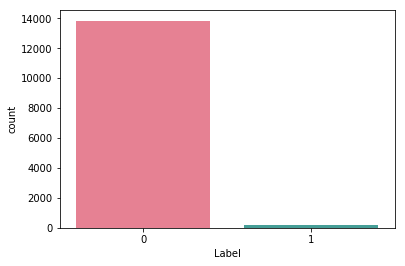

In [13]:
g0 = sns.countplot(x='Label', data = df_train, palette='husl')

In [14]:
total = df_train['Label'].count()
percent = ((df_train['Label'] == 1).sum())*100/total
print percent,'% were clicked'

1 % were clicked


In [30]:
df_train['device_id'].value_counts()

8127     10
544       7
260       6
13008     6
4506      6
2558      5
6986      5
3188      5
6043      5
3620      5
9851      4
6430      4
6218      4
12308     4
9448      4
1460      4
5797      4
7441      4
7813      4
10030     4
9091      3
1038      3
9260      3
12563     3
200       3
2352      3
7785      3
11791     3
10186     3
8147      3
         ..
7129      1
5080      1
11215     1
9166      1
5128      1
1034      1
5192      1
3083      1
11327     1
9278      1
3131      1
1082      1
7225      1
5176      1
11311     1
9262      1
3115      1
1066      1
7209      1
5160      1
11295     1
9246      1
3099      1
1050      1
7193      1
5144      1
11279     1
9230      1
13324     1
0         1
Name: device_id, Length: 13327, dtype: int64

In [31]:
df_train['Label'].value_counts()

0    13819
1      181
Name: Label, dtype: int64

In [15]:
get_missing_values(df_train)

('Dataframe total rows:', 14000)


,Total,Percent
creative_width,2125,15.178571
creative_height,2125,15.178571
timezone_offset,17,0.121429
action_list_1,0,0.000000
auction_categorical_10,0,0.000000
auction_categorical_1,0,0.000000
auction_categorical_0,0,0.000000
auction_boolean_2,0,0.000000
auction_boolean_1,0,0.000000
auction_boolean_0,0,0.000000


In [16]:
#Deleting missin values 
df_train.dropna(inplace=True)

In [17]:
#import pandas as pd
#from sklearn import metrics
#from sklearn import preprocessing
#from sklearn.feature_selection import RFE
#from sklearn.svm import SVR
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
#
#def ref_feature_select(data_frame,target_name, n_feats):
#    
#    X_train, X_test, y_train, y_test = train_test_split(data_frame.drop(target_name,axis = 1),data_frame[target_name])
#    
#    scaler = StandardScaler()
#    
#    X_train = scaler.fit_transform(X_train)
#    X_test  = scaler.transform(X_test)
#    
#    estimator = SVR(kernel='linear')
#    selector = RFE(estimator, n_features_to_select=n_feats, step = 1)
#    _ = selector.fit(X_train, y_train)
#
#    scores = pd.DataFrame()
#    scores["Attribute Name"] = data_frame.drop(target_name,axis = 1).columns
#    scores["Ranking"] = selector.ranking_
#    scores["Support"] = selector.support_
#
#    return scores

In [18]:
#ref_feature_select(X,'Label', n_feats=5)

In [19]:
#from google.colab import files
#files.upload()

In [20]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [21]:
#df_train = pd.read_csv('df_train_new.zip',compression='zip', header=0)
#df_train = df_train.sample(10000)
#df_train = drop_columns(df_train, 'Unnamed: 0')

In [22]:

#kf = KFold(n_splits=3, shuffle = True)
#estim = SVR(kernel='linear')
#select = RFE(estim, step = 1,  verbose = 1)
#
#pipe = Pipeline([
#  ('feat_sel', select),
#  ('reg', estim)])
#
#param_grid = {  'feat_sel__n_features_to_select' : np.arange(1,len(df_train.columns)),
#                'reg__C' : [0.1, 1, 10] }
#
#estim = GridSearchCV(pipe, param_grid, verbose=1, n_jobs = -1)
#
#estim.fit(df_train.drop('Label',axis = 1), df_train['Label'])

In [23]:
#pd.DataFrame(estim.cv_results_)

In [24]:
#estim.best_estimator_

## Eliminación Recursiva de Features 
### seleccionar mediante CrossValidation la cantidad de features a retener.

El método RFECV() toma los siguientes argumentos:

   * estimator: análogo a RFE, un estimador de aprendizaje supervisado con un atributo coef_ o feature_selection
   * steps: la cantidad de features que se elimina en cada iteración (puede pasarse en relativo o en absoluto).
   * cv: determina el método de valdiación cruzada. Puede pasarse un iterador.

Fitting estimator with 43 features.
Fitting estimator with 43 features.
Fitting estimator with 43 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 42 features.
Fitting estimator with 42 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 41 features.
Fitting estimator with 41 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 40 features.
Fitting estimator with 40 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 39 features.
Fitting estimator with 39 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 38 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 37 features.
Fitting estimator with 36 fe

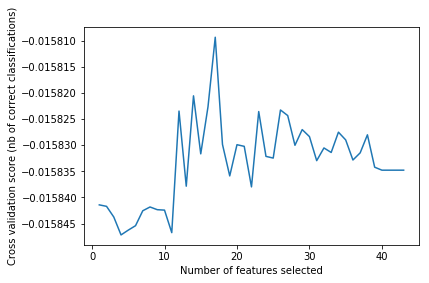

In [25]:
#Getting best features with RFECV
best_features_rfecv = get_best_features(df_train,'Label', 2)

In [37]:
#WHat are now the columns that should be deleted and how used?
target = df_train.drop('Label', axis=1).loc[:,best_features_rfecv].columns

features_tb_deleted = [col for col in df_train.drop('Label', axis=1).columns if col not in target]
features_tb_used = [col for col in df_train.columns if col not in features_tb_deleted]
len(features_tb_used)

KeyError: IndexError('indices are out-of-bounds',)

In [27]:
#Podemos conocer cuáles son las variables seleccionadas luego del proceso de validación cruzada: (Con RFE)
print('Best features :', df_train.drop('Label', axis=1).loc[:,features_tb_used].columns)
print('Lenght: ', len(features_tb_used))

('Best features :', Index([u'Label', u'action_categorical_0', u'action_categorical_1',
       u'action_categorical_5', u'action_categorical_6', u'action_list_0',
       u'auction_categorical_0', u'auction_categorical_1',
       u'auction_categorical_12', u'auction_categorical_6',
       u'creative_categorical_0', u'creative_categorical_1',
       u'creative_categorical_4', u'creative_categorical_8', u'creative_width',
       u'device_id_type', u'has_video', u'timezone_offset'],
      dtype='object'))
('Lenght: ', 18)


In [47]:
#Saving to file
np.savetxt('features_tb_used_train.csv',features_tb_used, delimiter=",", fmt='%s')
features_tb_used

['Label',
 'action_categorical_0',
 'action_categorical_1',
 'action_categorical_5',
 'action_categorical_6',
 'action_list_0',
 'auction_categorical_0',
 'auction_categorical_1',
 'auction_categorical_12',
 'auction_categorical_6',
 'creative_categorical_0',
 'creative_categorical_1',
 'creative_categorical_4',
 'creative_categorical_8',
 'creative_width',
 'device_id_type',
 'has_video',
 'timezone_offset']

Feature ranking:
1. feature 30 (0.090952)
2. feature 39 (0.086152)
3. feature 29 (0.070677)
4. feature 19 (0.067403)
5. feature 11 (0.065810)
6. feature 21 (0.064282)
7. feature 18 (0.058160)
8. feature 9 (0.047895)
9. feature 4 (0.044774)
10. feature 15 (0.041789)
11. feature 27 (0.041661)
12. feature 10 (0.035756)
13. feature 24 (0.032030)
14. feature 25 (0.030405)
15. feature 2 (0.028853)
16. feature 28 (0.017329)
17. feature 36 (0.015627)
18. feature 34 (0.015168)
19. feature 37 (0.014700)
20. feature 8 (0.012259)
21. feature 26 (0.012000)
22. feature 20 (0.011242)
23. feature 38 (0.011158)
24. feature 31 (0.010719)
25. feature 1 (0.008856)
26. feature 16 (0.008595)
27. feature 3 (0.008063)
28. feature 7 (0.007726)
29. feature 41 (0.007378)
30. feature 23 (0.005515)
31. feature 0 (0.004190)
32. feature 40 (0.004137)
33. feature 42 (0.003980)
34. feature 22 (0.003976)
35. feature 5 (0.003170)
36. feature 35 (0.003055)
37. feature 12 (0.002735)
38. feature 6 (0.001679)
39. feature 13

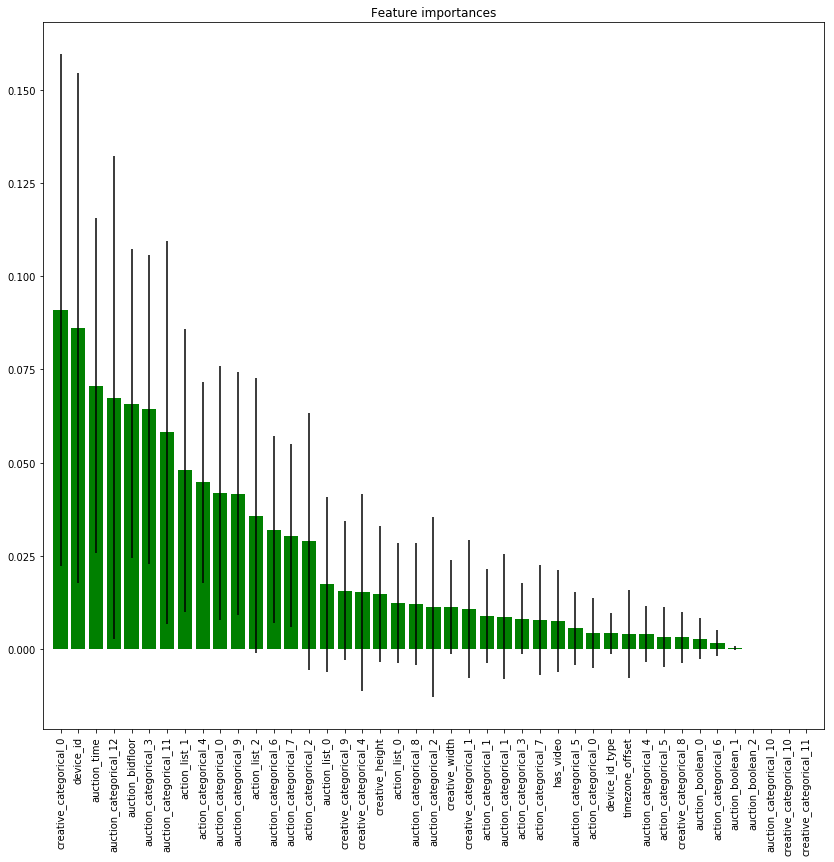

In [33]:
#Getting best features and their rankings with Random Forest BEFORE drop columns
df_train.dropna(inplace=True)
best_features_random_forest = get_best_features_importance(df_train,'Label')

In [34]:
best_features_random_forest

Index([u'creative_categorical_0', u'device_id', u'auction_time',
       u'auction_categorical_12', u'auction_bidfloor',
       u'auction_categorical_3', u'auction_categorical_11', u'action_list_1',
       u'action_categorical_4', u'auction_categorical_0',
       u'auction_categorical_9', u'action_list_2', u'auction_categorical_6',
       u'auction_categorical_7', u'action_categorical_2', u'auction_list_0',
       u'creative_categorical_9', u'creative_categorical_4',
       u'creative_height', u'action_list_0', u'auction_categorical_8',
       u'auction_categorical_2', u'creative_width', u'creative_categorical_1',
       u'action_categorical_1', u'auction_categorical_1',
       u'action_categorical_3', u'action_categorical_7', u'has_video',
       u'auction_categorical_5', u'action_categorical_0', u'device_id_type',
       u'timezone_offset', u'auction_categorical_4', u'action_categorical_5',
       u'creative_categorical_8', u'auction_boolean_0',
       u'action_categorical_6', u'aucti

In [38]:
# Deleting columns
for col in features_tb_deleted:
    df_train = drop_columns(df_train, col)


KeyError: "['action_categorical_2'] not found in axis"

In [39]:
df_train.columns

Index([u'Label', u'action_categorical_0', u'action_categorical_1',
       u'action_categorical_5', u'action_categorical_6', u'action_list_0',
       u'auction_categorical_0', u'auction_categorical_1',
       u'auction_categorical_12', u'auction_categorical_6',
       u'creative_categorical_0', u'creative_categorical_1',
       u'creative_categorical_4', u'creative_categorical_8', u'creative_width',
       u'device_id_type', u'has_video', u'timezone_offset'],
      dtype='object')

In [41]:
df_train.shape

(11858, 18)

In [42]:
df_train.head(5)

,Label,action_categorical_0,action_categorical_1,action_categorical_5,action_categorical_6,action_list_0,auction_categorical_0,auction_categorical_1,auction_categorical_12,auction_categorical_6,creative_categorical_0,creative_categorical_1,creative_categorical_4,creative_categorical_8,creative_width,device_id_type,has_video,timezone_offset
0,0,4,8,0,1,3,106,1,790,5,110,1,0,3,300.0,2,False,1.0
1,0,4,7,0,1,3,195,1,965,4,92,1,0,3,300.0,1,False,1.0
2,0,1,13,1,1,4,208,0,913,33,315,1,0,3,300.0,1,False,4.0
3,0,1,13,1,1,4,189,0,440,33,96,1,0,3,300.0,1,False,4.0
4,0,7,2,0,1,1,96,1,433,8,219,0,0,3,320.0,2,False,1.0


Feature ranking:
1. feature 9 (0.213307)
2. feature 7 (0.211081)
3. feature 5 (0.147155)
4. feature 8 (0.145795)
5. feature 13 (0.058320)
6. feature 1 (0.043445)
7. feature 0 (0.026732)
8. feature 4 (0.025521)
9. feature 14 (0.023537)
10. feature 15 (0.021682)
11. feature 11 (0.021256)
12. feature 6 (0.019034)
13. feature 10 (0.012044)
14. feature 12 (0.010786)
15. feature 16 (0.008182)
16. feature 3 (0.007734)
17. feature 2 (0.004389)


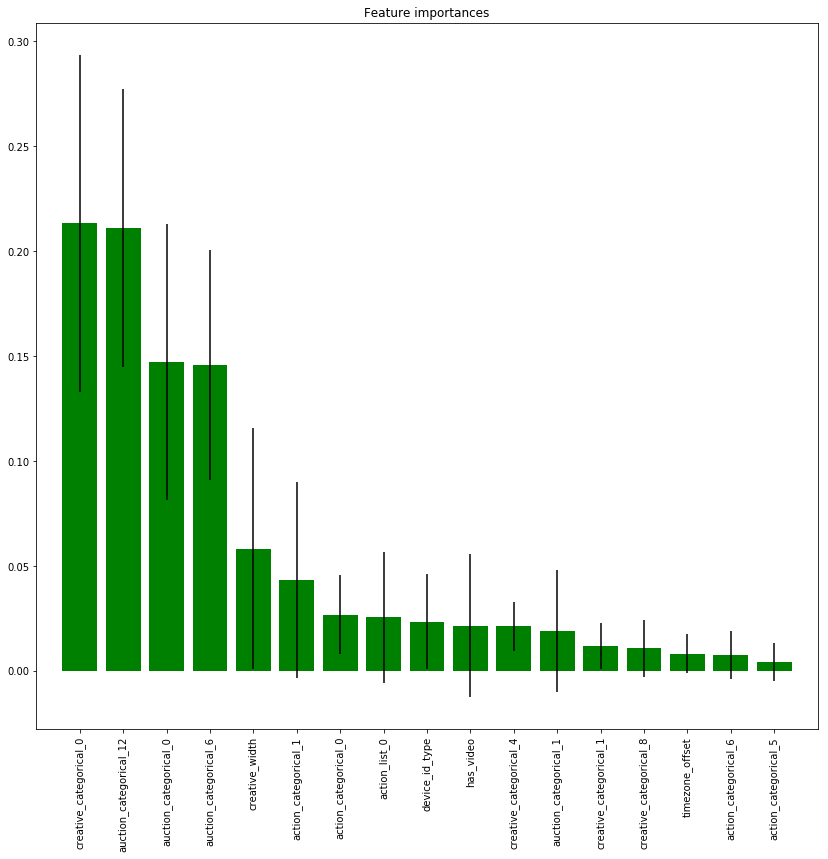

In [43]:
#Getting best features and their rankings with Random Forest
#df_train.dropna(inplace=True)
best_features_random_forest = get_best_features_importance(df_train,'Label')

In [ ]:
#COLUMNAS_A_ELIMINAR=["auction_age"];
#Elimino columnas
#df_train_sample = drop_columns(df_train_sample, COLUMNAS_A_ELIMINAR)

In [ ]:
#df_train_sample2.to_csv('df_train_new.csv')


In [ ]:
#missing_data.loc[missing_data['Percent'] > 0.81]

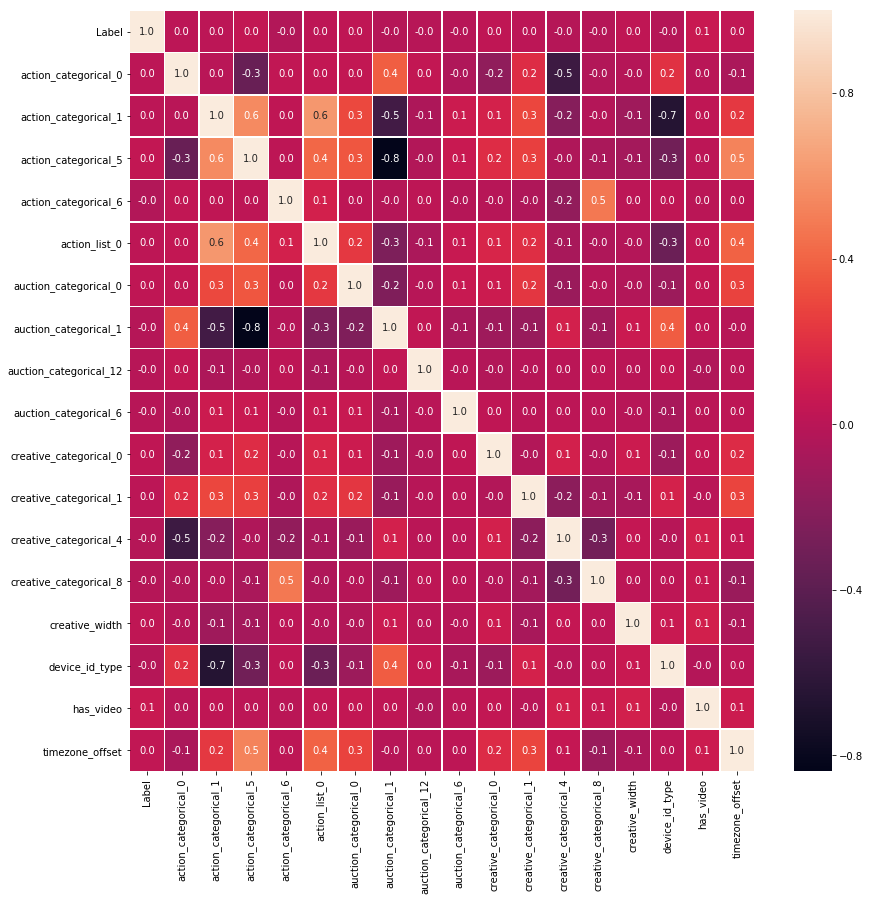

In [44]:
#Feature correlation
#correlation map
f,ax = plt.subplots(figsize=(14, 14))
sns.heatmap(df_train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [45]:
df_train.dtypes

Label                       int64
action_categorical_0        int64
action_categorical_1        int64
action_categorical_5        int64
action_categorical_6        int64
action_list_0               int64
auction_categorical_0       int64
auction_categorical_1       int64
auction_categorical_12      int64
auction_categorical_6       int64
creative_categorical_0      int64
creative_categorical_1      int64
creative_categorical_4      int64
creative_categorical_8      int64
creative_width            float64
device_id_type              int64
has_video                    bool
timezone_offset           float64
dtype: object

In [ ]:
#pd.read_csv('data/train/ctr_15.zip', compression='zip', header=0).drop(["Label"], axis = 1).to_csv('df_train_wo_label.csv')
#pd.get_dummies(pd.read_csv('df_train_wo_label.csv'), prefix='prfx').to_csv('df_train_wo_label_dummies.csv')
#df3 = pd.get_dummies(df3, prefix='prfx')

# 4. Running Machine Learning Algorithms
   
####  We will explore the following models:

   - 1. SGD Based Logistic regression
   - 2. Gaussian Naive Bayes
   - 3. Decision Tree Classifier
   - 4. Random Forest
   
   

In [5]:
features_tb_used = np.loadtxt('features_tb_used_train.csv', dtype='str')

#x_test = pd.read_csv('data/ctr_test_labeled.zip', usecols=features_tb_used, compression='zip', header=0)
#y_test = pd.read_csv('data/ctr_test_labeled.zip', usecols=['Label'], compression='zip', header=0)

all_files = glob.glob(os.path.join('data/train/', "*.zip"))     # advisable to use os.path.join as this makes concatenation OS independent
print 'Training files', all_files
#df_from_each_file = (pd.read_csv(f, compression='zip', header=0) for f in all_files)
x_train = pd.DataFrame()

for f in all_files:
    print 'working with ', f
    df_temp = pd.read_csv(f,usecols=features_tb_used, compression='zip', header=0)
    #df_temp = df_temp.sample(20000)
    df_temp.reset_index(drop=True, inplace=True)
    x_train = pd.concat( [x_train, df_temp], ignore_index=True)
    print x_train.shape
    
df_temp=np.nan

Training files ['data/train/ctr_21.zip', 'data/train/ctr_15.zip', 'data/train/ctr_16.zip', 'data/train/ctr_18.zip', 'data/train/ctr_17.zip', 'data/train/ctr_20.zip', 'data/train/ctr_19.zip']
working with  data/train/ctr_21.zip
(1523221, 18)
working with  data/train/ctr_15.zip
(2762745, 18)
working with  data/train/ctr_16.zip
(3855158, 18)
working with  data/train/ctr_18.zip
(4868739, 18)
working with  data/train/ctr_17.zip
(5962346, 18)
working with  data/train/ctr_20.zip
(7318412, 18)
working with  data/train/ctr_19.zip
(8644592, 18)


In [14]:
#np.savetxt('x_train_concated.csv',x_train, delimiter=",", fmt='%s', header=1)
#x_train = np.loadtxt('features_tb_used_train.csv', dtype='str')
#x_train

MemoryError: 

In [6]:
#missing data
get_missing_values(x_train)

('Dataframe total rows:', 5113601)


,Total,Percent
timezone_offset,0,0.0
auction_categorical_12,0,0.0
action_categorical_1,0,0.0
action_categorical_5,0,0.0
action_categorical_6,0,0.0
action_list_0,0,0.0
auction_categorical_0,0,0.0
auction_categorical_1,0,0.0
auction_categorical_6,0,0.0
has_video,0,0.0


In [6]:
#Removing NANs from x_train 
print len(x_train.index)
x_train.dropna(axis=0, inplace=True)
y_train=x_train["Label"]

x_train=x_train.drop(["Label"], axis = 1)
print len(x_train.index)

8644592
5113601


In [6]:
# Encodes non-float labels to new unique interger values
x_train = labelEncode(col_names_encode_list, x_train, True, False, False)
# Saving fit to disk
#np.save(labelencoderfile, le.classes_)

begin
processing column  action_categorical_0
Saving file  action_categorical_0labelEncode.save.npy  with  9  values
processing column  action_categorical_1
Saving file  action_categorical_1labelEncode.save.npy  with  14  values
processing column  action_categorical_2
ERROR on processing column  action_categorical_2 , error: 'action_categorical_2'
processing column  action_categorical_3
ERROR on processing column  action_categorical_3 , error: 'action_categorical_3'
processing column  action_categorical_4
ERROR on processing column  action_categorical_4 , error: 'action_categorical_4'
processing column  action_categorical_5
Saving file  action_categorical_5labelEncode.save.npy  with  2  values
processing column  action_categorical_6
Saving file  action_categorical_6labelEncode.save.npy  with  1  values
processing column  action_categorical_7
ERROR on processing column  action_categorical_7 , error: 'action_categorical_7'
processing column  action_list_0
Saving file  action_list_0labelE

In [23]:
le.classes_

array([0, 1, 2, 3])

In [25]:
x_train.head(10)

,action_categorical_0,action_categorical_1,action_categorical_5,action_categorical_6,action_list_0,auction_categorical_0,auction_categorical_1,auction_categorical_12,auction_categorical_6,creative_categorical_0,creative_categorical_1,creative_categorical_4,creative_categorical_8,creative_width,device_id_type,has_video,timezone_offset
0,8,10,0,0,5,437,1,5647,22,213,0,0,0,300.0,1,False,1.0
1,4,7,0,0,3,437,1,2552,47,22,1,1,0,320.0,1,False,1.0
2,6,5,0,0,4,1674,2,5627,47,421,1,0,0,320.0,3,False,10.0
3,1,13,1,0,4,473,0,3543,86,129,1,0,0,300.0,1,False,4.0
4,1,13,1,0,4,473,0,1949,178,92,1,0,0,300.0,1,False,4.0
5,7,2,0,0,1,704,1,7108,22,303,0,0,0,320.0,3,False,1.0
6,1,13,1,0,4,1679,0,7291,12,92,1,0,0,300.0,1,False,4.0
7,1,13,1,0,4,473,0,7291,178,546,1,1,0,320.0,1,False,4.0
9,0,6,0,0,2,800,1,7665,47,28,0,1,0,320.0,1,False,1.0
11,0,0,0,0,2,260,1,5686,86,179,0,1,0,320.0,3,False,1.0


In [7]:
#Saving consolidated train to disk for testing and performance porposes
x_train.to_csv('x_train_consolidated.csv.zip',compression='zip')
y_train.to_csv('y_train_consolidated.csv.zip',compression='zip')
x_train=np.nan
y_train=np.nan

In [7]:
#Adding test values to Encoding
#Loading test
x_test = pd.read_csv('data/ctr_test_labeled.zip', usecols=features_tb_used, compression='zip', header=0)
#Removing NANs from x_test 
print len(x_test.index)
x_test.dropna(axis=0, inplace=True)
y_test=x_test["Label"]
x_test=x_test.drop(["Label"], axis = 1)
print len(y_test.index)

#Loading Train
#x_train = pd.read_csv('x_train_consolidated.csv.zip', compression='zip')

x_test.reset_index(drop=True, inplace=True)
x_train = pd.concat( [x_train, x_test], ignore_index=True)

# Encodes non-float labels to new unique interger values
x_train = labelEncode(col_names_encode_list, x_train, True, False, False)



1139639
828319
begin
processing column  action_categorical_0
Saving file  action_categorical_0labelEncode.save.npy  with  11  values
processing column  action_categorical_1
Saving file  action_categorical_1labelEncode.save.npy  with  17  values
processing column  action_categorical_2
ERROR on processing column  action_categorical_2 , error: 'action_categorical_2'
processing column  action_categorical_3
ERROR on processing column  action_categorical_3 , error: 'action_categorical_3'
processing column  action_categorical_4
ERROR on processing column  action_categorical_4 , error: 'action_categorical_4'
processing column  action_categorical_5
Saving file  action_categorical_5labelEncode.save.npy  with  2  values
processing column  action_categorical_6
Saving file  action_categorical_6labelEncode.save.npy  with  1  values
processing column  action_categorical_7
ERROR on processing column  action_categorical_7 , error: 'action_categorical_7'
processing column  action_list_0
Saving file  act

In [8]:
#Loading test
x_test = pd.read_csv('data/ctr_test_labeled.zip', usecols=features_tb_used, compression='zip', header=0)

In [9]:
#Removing NANs from x_test 
print len(x_test.index)
x_test.dropna(axis=0, inplace=True)
y_test=x_test["Label"]
x_test=x_test.drop(["Label"], axis = 1)
print len(y_test.index)

1139639
828319


In [10]:
# Encodes non-float labels to new unique interger values, using pre-fitted values
x_test = labelEncode(col_names_encode_list, x_test, True, False, True)


begin
processing column  action_categorical_0
using_saved_fit, file: action_categorical_0labelEncode.save.npy
processing column  action_categorical_1
using_saved_fit, file: action_categorical_1labelEncode.save.npy
processing column  action_categorical_2
ERROR on processing column  action_categorical_2 , error: [Errno 2] No such file or directory: 'action_categorical_2labelEncode.save.npy'
processing column  action_categorical_3
ERROR on processing column  action_categorical_3 , error: [Errno 2] No such file or directory: 'action_categorical_3labelEncode.save.npy'
processing column  action_categorical_4
ERROR on processing column  action_categorical_4 , error: [Errno 2] No such file or directory: 'action_categorical_4labelEncode.save.npy'
processing column  action_categorical_5
using_saved_fit, file: action_categorical_5labelEncode.save.npy
processing column  action_categorical_6
using_saved_fit, file: action_categorical_6labelEncode.save.npy
processing column  action_categorical_7
ERRO

In [11]:
#Saving y train test to disk for testing and performance porposes
x_test.to_csv('x_test_consolidated.csv.zip',compression='zip')
y_test.to_csv('y_test_consolidated.csv.zip',compression='zip')

In [15]:
x_test

,action_categorical_0,action_categorical_1,action_categorical_5,action_categorical_6,action_list_0,auction_categorical_0,auction_categorical_1,auction_categorical_12,auction_categorical_6,creative_categorical_0,creative_categorical_1,creative_categorical_4,creative_categorical_8,creative_width,device_id_type,has_video,timezone_offset
0,5,10,0,0,4,898,1,7503,12,228,1,0,0,300.0,1,False,1.0
1,5,10,0,0,4,559,1,7283,39,284,1,0,0,320.0,1,False,1.0
2,5,10,0,0,4,898,1,8970,12,284,1,0,0,320.0,1,False,1.0
3,8,3,0,0,2,1022,1,6596,39,68,1,0,0,320.0,3,False,1.0
4,1,1,1,0,0,1377,2,3104,180,512,1,0,0,320.0,3,False,10.0
5,5,10,0,0,4,138,1,5479,58,106,1,1,0,320.0,1,False,1.0
6,9,7,1,0,0,346,2,6690,73,50,1,0,0,300.0,1,False,10.0
8,1,9,1,0,0,492,2,1541,180,7,1,0,0,300.0,1,False,10.0
9,8,14,0,0,2,138,1,8927,50,68,1,0,0,320.0,1,False,1.0
10,10,13,0,0,6,1022,1,3359,58,17,0,0,0,300.0,1,False,1.0


In [15]:
#We could start from this point
features_tb_used = np.loadtxt('features_tb_used_train.csv', dtype='str')

x_train = pd.read_csv('x_train_consolidated.csv.zip', compression='zip')
y_train = pd.read_csv('y_train_consolidated.csv.zip', compression='zip')

x_test = pd.read_csv('x_test_consolidated.csv.zip', compression='zip')
y_test = pd.read_csv('y_test_consolidated.csv.zip', compression='zip')

In [5]:
y_train.drop(['0'], axis = 1, inplace=True)
y_test.drop(["0"], axis = 1, inplace=True)
x_train.drop(['Unnamed: 0'], axis = 1, inplace=True)
x_test.drop(["Unnamed: 0"], axis = 1, inplace=True)

In [6]:
y_test.rename(index=str, columns={"0.1": "Label"}, inplace=True)
y_train.rename(index=str, columns={"0.1": "Label"}, inplace=True)

In [16]:
y_train.shape

(5113601,)

In [8]:
x_train.shape

(5113601, 17)

In [9]:
x_train.drop(x_train.head(1).index, inplace=True)
x_test.drop(x_test.head(1).index, inplace=True)


In [10]:

#StandardScaler

scaler = StandardScaler()

#predictors = df_train.drop(["Label"], axis = 1)
#target = df_train["Label"]
#x_train, x_test, y_train, y_test = train_test_split(x_test, y_test, test_size = 0.4, random_state = 0)

# Scaling the values for the parameters
x_train = scaler.fit_transform(x_train)
x_test  = scaler.transform(x_test)


In [15]:
# Support Vector Machine NOT executed
#svc = SVC()
#start_time = time.clock()
#svc.fit(x_train, y_train)
#fit_time = time.clock() - start_time
#print "Fit time", fit_time, "seconds"
#
## Make predictions
#y_test_pred = svc.predict(x_test)
#
#acc_svc = svc.score(x_test, y_test)
#acc_svc
#print("MSE", np.square(mean_squared_error(y_test,y_test_pred)), "\n"
#     "score=",  acc_svc, "\n")

In [ ]:
# K-Nearest Neighbors NOT executed
#knn = KNeighborsClassifier(n_jobs=2)
#start_time = time.clock()
#knn.fit(x_train, y_train)
#fit_time = time.clock() - start_time
#print "Fit time", fit_time, "seconds"
##y_pred = knn.predict(x_val)
#y_test_pred = knn.predict(x_test)
#acc_knn = knn.score(x_test, y_test)
#acc_knn
#print("MSE", np.square(mean_squared_error(y_test,y_test_pred)), "\n"
#     "score=",  acc_knn, "\n")

/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


SGD Based Logistic regression model training complete..."		10.0s
✔  ROC AUC score on test set: 0.611
✔  SGD Based Logistic regression model saved...
('MSE', 0.00010347515382530107, '\nscore=', 0.989785323993925, '\n')


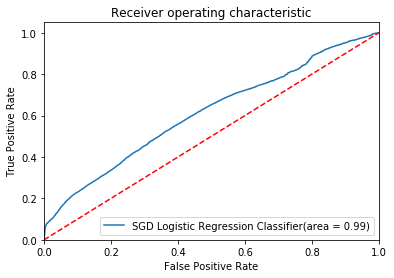

Confusion Matrix :
[[819851     44]
 [  8417      6]]
Accuracy Score : 0.989785323993925
Report : 
             precision    recall  f1-score   support

          0       0.99      1.00      0.99    819895
          1       0.12      0.00      0.00      8423

avg / total       0.98      0.99      0.98    828318



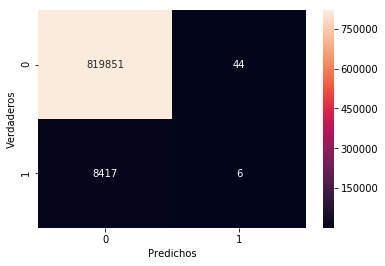

In [27]:
#Running Machine Learning Algorithms
#1. SGD Based Logistic regression
sgd_logistic_reg(x_train, y_train, x_test, y_test)


Gaussian Naive Bayes model training complete..."		2.3s
✔  ROC AUC score on test set: 0.616
✔  Gaussian Naive Bayes model saved...
('MSE', 0.0011562617307240186, '\nscore=', 0.9659961512366023, '\n')


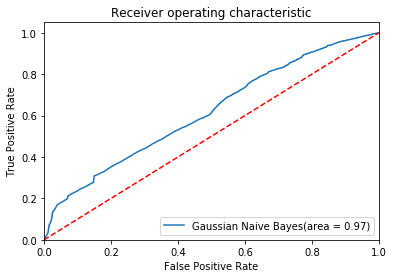

Confusion Matrix :
[[799026  20869]
 [  7297   1126]]
Accuracy Score : 0.9659961512366023
Report : 
             precision    recall  f1-score   support

          0       0.99      0.97      0.98    819895
          1       0.05      0.13      0.07      8423

avg / total       0.98      0.97      0.97    828318



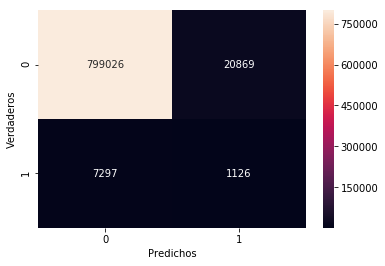

In [28]:
#2. #Gaussian
gaussian_naive_bayes(x_train, y_train, x_test, y_test)

Decision Tree Classifier model training complete..."		85.5s
✔  ROC AUC score on test set: 0.511
✔  Decision Tree Classifier model saved...
('MSE', 0.0007664603059051786, '\nscore=', 0.9723149804785118, '\n')


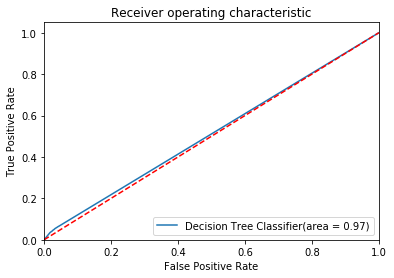

Confusion Matrix :
[[805088  14807]
 [  8125    298]]
Accuracy Score : 0.9723149804785118
Report : 
             precision    recall  f1-score   support

          0       0.99      0.98      0.99    819895
          1       0.02      0.04      0.03      8423

avg / total       0.98      0.97      0.98    828318



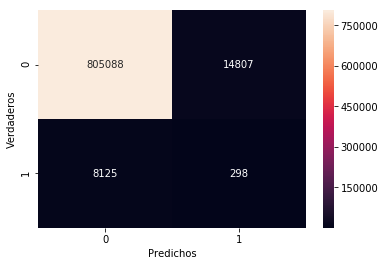

In [29]:
# 3. Decision Tree Classifier
dec_tree(x_train, y_train, x_test, y_test)

Random Forest Classifier model training complete..."		288.1s
✔  ROC AUC score on test set: 0.544
✔  Random Forest Classifier model saved...
('MSE', 0.00010490764105970463, '\nscore=', 0.9897575568803285, '\n')


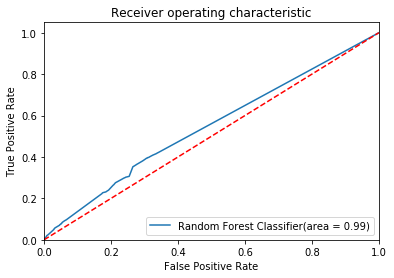

Confusion Matrix :
[[819827     68]
 [  8416      7]]
Accuracy Score : 0.9897575568803285
Report : 
             precision    recall  f1-score   support

          0       0.99      1.00      0.99    819895
          1       0.09      0.00      0.00      8423

avg / total       0.98      0.99      0.98    828318



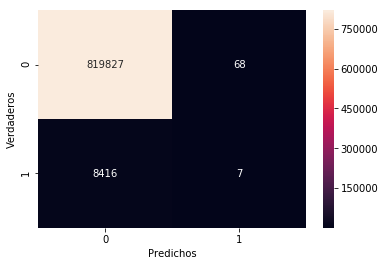

In [30]:
#4. Random forest
random_forest(x_train, y_train, x_test, y_test)

In [31]:
df_resultados

,Model,Score,ROC AUC score on test set,Fit Time (seconds)
0,SGD Logistic Regression Classifier,0.989785,0.610681,9.999558
1,Gaussian Naive Bayes,0.965996,0.616355,2.316375
2,Decision Tree Classifier,0.972315,0.510933,85.523850
3,Random Forest Classifier,0.989758,0.543882,288.103164


In [205]:
#Predicting values

#Loading test
x_test_l = pd.read_csv('data/ctr_test_labeled.zip', usecols=features_tb_used, compression='zip', header=0)
x_test_l.dropna(axis=0, inplace=True)
x_test_l = x_test_l.sample(1) 
#x_test_l = x_test_l[x_test_l["Label"]==1]
y_test_l=x_test_l["Label"]
x_test_l=x_test_l.drop(["Label"], axis = 1)
print len(y_test_l.index)


1


In [199]:
y_test_l

45         1
122        1
526        1
594        1
692        1
793        1
1053       1
1207       1
1998       1
2180       1
2270       1
2302       1
2379       1
2685       1
2733       1
2981       1
3153       1
3271       1
3312       1
3323       1
3348       1
3575       1
3807       1
3846       1
4138       1
4270       1
4602       1
4644       1
4773       1
4876       1
          ..
1135451    1
1135725    1
1135881    1
1135887    1
1135943    1
1136241    1
1136313    1
1136564    1
1136578    1
1136626    1
1136711    1
1136804    1
1136876    1
1137072    1
1137249    1
1137380    1
1137978    1
1138082    1
1138246    1
1138392    1
1138599    1
1138776    1
1138782    1
1138785    1
1138852    1
1139086    1
1139115    1
1139471    1
1139482    1
1139558    1
Name: Label, Length: 8423, dtype: int64

('SGD Logistic Reggression', ' time to complete (including labelENcode function):"\t\t92.0ms')
('SGD Logistic Reggression', ' time to complete (without labelENcode function):"\t\t1.0ms')
('MSE', 0.0, 'score=', 1.0, '\n')
Confusion Matrix :
[[1]]
Accuracy Score : 1.0
Report : 
             precision    recall  f1-score   support

          0       1.00      1.00      1.00         1

avg / total       1.00      1.00      1.00         1



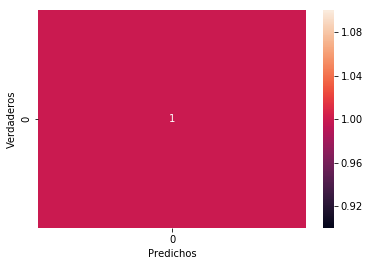

In [238]:
model_name = 'SGD Logistic Reggression'
l_reg_file = open(log_reg_file, 'rb')
model = pickle.load(l_reg_file)



start_time = int(round(time.time() * 1000))
# Encodes non-float labels to new unique interger values USING pre fitted values
x_test_l = labelEncode(col_names_encode_list_test, x_test_l, False, False, True)

# Run model on test set
start_pred_time = int(round(time.time() * 1000))
predictions = model.predict_proba(x_test_l)[:, 1]
tot_time = int(round(time.time() * 1000)) - start_time
pred_time = int(round(time.time() * 1000)) - start_pred_time
y_test_pred = model.predict(x_test_l)
 
print(model_name, ' time to complete (including labelENcode function):"\t\t{0:.1f}ms'.format(tot_time))

print(model_name, ' time to complete (without labelENcode function):"\t\t{0:.1f}ms'.format(pred_time))


# Evaluate model
score = model.score(x_test_l, y_test_l)
  

print("MSE", np.square(mean_squared_error(y_test_l,predictions)), "score=",  score, "\n")

#matriz de confusión
print_confusion_matrix(y_test_l, y_test_pred)


    

In [181]:
model.classes_

array([0, 1])

In [171]:
predictions = model.predict_proba(x_test_l)
sum(predictions)

array([1044.69981824,   65.30018176])

In [186]:
list(predictions)#array, shape (n_samples, n_classes)

[0.3, 0.22100840336134456]

In [163]:
prob_per_class_dictionary = dict(zip(model.classes_, predictions))

# gets a list of ['most_probable_class', 'second_most_probable_class', ..., 'least_class']
results_ordered_by_probability = map(lambda x: x[0], sorted(zip(model.classes_, predictions), key=lambda x: x[1], reverse=True))

In [165]:
prob_per_class_dictionary

{0: 9.337259082591382e-204, 1: 1.893050087131593e-174}

In [166]:
list(results_ordered_by_probability)

[1, 0]

In [129]:
y_test_l

127370    0
Name: Label, dtype: int64

In [67]:
x_test_l

,action_categorical_0,action_categorical_1,action_categorical_5,action_categorical_6,action_list_0,auction_categorical_0,auction_categorical_1,auction_categorical_12,auction_categorical_6,creative_categorical_0,creative_categorical_1,creative_categorical_4,creative_categorical_8,creative_width,device_id_type,has_video,timezone_offset
838363,9,7,1,0,0,705,2,4159,50,50,1,0,0,300.0,1,False,10.0
